In [53]:
import pandas as pd
import numpy as np

In [54]:
np.random.seed(42)

ROWS = 12000

data = {
    # Demographics
    "age": np.random.randint(25, 85, ROWS),
    "sex": np.random.binomial(1, 0.55, ROWS),  # 55% male
    
    # Clinical measurements
    "cholesterol": np.random.normal(240, 50, ROWS),
    "resting_bp": np.random.normal(135, 20, ROWS),
    "max_heart_rate": np.random.normal(150, 25, ROWS),
    
    # Blood indicators
    "fasting_blood_sugar": np.random.binomial(1, 0.25, ROWS),
    "blood_sugar_level": np.random.normal(110, 30, ROWS),
    
    # Symptoms
    "exercise_angina": np.random.binomial(1, 0.3, ROWS),
    "oldpeak": np.abs(np.random.normal(1.5, 1.2, ROWS)),
    
    # Lifestyle / history
    "smoking": np.random.binomial(1, 0.35, ROWS),
    "obesity": np.random.binomial(1, 0.4, ROWS),
}

df = pd.DataFrame(data)

# --- Introduce medical realism ---
df["cholesterol"] = df["cholesterol"].clip(120, 450)
df["resting_bp"] = df["resting_bp"].clip(80, 200)
df["max_heart_rate"] = df["max_heart_rate"].clip(60, 210)
df["blood_sugar_level"] = df["blood_sugar_level"].clip(60, 300)
df["oldpeak"] = df["oldpeak"].clip(0, 6)

# --- Disease probability logic (REALISTIC) ---
risk_score = (
    0.03 * df["age"] +
    0.02 * df["cholesterol"] +
    0.025 * df["resting_bp"] +
    0.04 * df["fasting_blood_sugar"] * 100 +
    0.05 * df["exercise_angina"] * 100 +
    0.04 * df["smoking"] * 100 +
    0.04 * df["obesity"] * 100 +
    0.03 * df["oldpeak"] * 10 -
    0.02 * df["max_heart_rate"]
)

probability = 1 / (1 + np.exp(-0.03 * (risk_score - risk_score.mean())))

df["target"] = (probability > 0.65).astype(int)

# --- Enforce class imbalance (industry realistic) ---
# ~80% healthy, ~20% disease
df.loc[df.sample(frac=0.25, random_state=42).index, "target"] = 0

# --- Inject missing values (noise) ---
for col in ["cholesterol", "resting_bp", "blood_sugar_level"]:
    df.loc[df.sample(frac=0.07, random_state=42).index, col] = np.nan

# --- Inject impossible values (dirty hospital data) ---
df.loc[df.sample(frac=0.01, random_state=42).index, "cholesterol"] = 0
df.loc[df.sample(frac=0.01, random_state=24).index, "resting_bp"] = 0

print(df.head())
print("\nShape:", df.shape)
print("\nTarget distribution:\n", df["target"].value_counts(normalize=True))




risk = (
    (df["cholesterol"] > 240).astype(int) +
    (df["resting_bp"] > 140).astype(int) +
    df["exercise_angina"] +
    df["smoking"] +
    df["obesity"] +
    (df["age"] > 55).astype(int)
)

df["target"] = (risk >= 3).astype(int)


   age  sex  cholesterol  resting_bp  max_heart_rate  fasting_blood_sugar  \
0   63    1   158.236706  171.826261      181.703149                    0   
1   76    1   307.802317  143.901204      126.261537                    0   
2   53    1   292.632469  159.715218      150.652781                    0   
3   39    1   216.365781  147.477747      191.136913                    0   
4   67    0   253.091766  126.739457      140.254895                    0   

   blood_sugar_level  exercise_angina   oldpeak  smoking  obesity  target  
0         177.554990                0  2.217908        1        1       0  
1          83.504048                1  1.480675        0        0       0  
2         112.736859                0  0.072005        1        0       0  
3         149.440470                0  2.377410        0        0       0  
4         109.788175                1  2.550232        0        0       0  

Shape: (12000, 12)

Target distribution:
 target
0    1.0
Name: proportion, dtyp

In [55]:
df

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,target
0,63,1,158.236706,171.826261,181.703149,0,177.554990,0,2.217908,1,1,1
1,76,1,307.802317,143.901204,126.261537,0,83.504048,1,1.480675,0,0,1
2,53,1,292.632469,159.715218,150.652781,0,112.736859,0,0.072005,1,0,1
3,39,1,216.365781,147.477747,191.136913,0,149.440470,0,2.377410,0,0,0
4,67,0,253.091766,126.739457,140.254895,0,109.788175,1,2.550232,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,57,1,NaN,NaN,166.054175,0,NaN,0,0.757018,1,1,1
11996,70,0,178.429561,123.167288,149.343325,1,107.229654,0,2.060941,0,0,0
11997,41,1,218.337595,152.408872,169.674321,0,150.730573,0,0.663092,1,0,0
11998,66,1,NaN,NaN,182.172033,0,NaN,0,0.956816,1,0,0


In [56]:
x = df.iloc[:,0 : -1]
y = df.iloc[:,-1]

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

TREATING CHOLESTEROL_COLUMN 

In [59]:
x_train[x_train['cholesterol'] == 0].shape

(93, 11)

In [60]:
# x_train['cholesterol'] = x_train['cholesterol'].replace(0, np.nan)
x_train['cholesterol']  = np.where(x_train['cholesterol']==0, np.nan, x_train['cholesterol'])

In [61]:
x_train[x_train['cholesterol'] == 0].shape


(0, 11)

In [62]:
x_train['cholesterol'].median()
# x_train[x_train['cholesterol'] == 0].shape

240.89575389135638

In [63]:
x_train['cholesterol'].fillna(x_train['cholesterol'].median(),inplace=True)

/tmp/ipython-input-4144291517.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train['cholesterol'].fillna(x_train['cholesterol'].median(),inplace=True)


RESTING_BP

In [64]:
df.head(1)

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,target
0,63,1,158.236706,171.826261,181.703149,0,177.55499,0,2.217908,1,1,1


In [65]:
df[df['resting_bp']  > 140].shape

(4393, 12)

In [66]:
x_train['alarming_resting_bp'] = np.where(x_train['resting_bp'] > 140, 1, 0)

In [67]:
x_test['alarming_resting_bp'] = np.where(x_test['resting_bp'] > 140, 1, 0)

In [68]:
x_train

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,alarming_resting_bp
1334,59,1,239.866891,149.983888,173.100849,0,89.895835,1,0.232852,0,0,1
939,54,1,181.801607,141.239849,153.748703,0,71.251784,0,0.327218,0,1,1
11114,42,0,254.205665,159.420727,177.047758,0,134.693158,0,1.026650,1,1,1
4409,62,0,226.321323,154.576117,117.807312,1,80.540098,0,0.343344,0,1,1
7486,44,1,272.177871,127.146291,176.387714,0,107.912611,1,1.974245,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2884,80,1,235.571487,139.280759,141.398893,1,76.641174,0,0.802115,0,1,0
5285,33,1,245.034537,132.367989,159.513838,1,159.054012,0,1.047009,0,1,0
8954,73,0,254.307844,129.241766,184.084410,0,133.718980,0,1.029126,0,0,0
9964,80,0,203.531732,134.528871,116.889212,0,60.000000,0,2.336391,1,0,0


In [69]:
x_train.loc[x_train['resting_bp'] == 0 ,'resting_bp'] = x_train['resting_bp'].median()

In [70]:
x_train[x_train['resting_bp'] ==0].shape

(0, 12)

MAX_HEART_RATE

In [71]:
x_train['max_heart_rate']

,max_heart_rate
1334,173.100849
939,153.748703
11114,177.047758
4409,117.807312
7486,176.387714
...,...
2884,141.398893
5285,159.513838
8954,184.084410
9964,116.889212


FASTING_BLOOD_SUGAR

In [72]:
x_train['fasting_blood_sugar'].isnull().sum()

np.int64(0)

BLOOD_SUGAR_LEVEL

In [73]:
x_train['blood_sugar_level'].fillna(x_train['blood_sugar_level'].median(),inplace=True)

/tmp/ipython-input-859570528.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train['blood_sugar_level'].fillna(x_train['blood_sugar_level'].median(),inplace=True)


EXERCISE_ANGiNA

In [74]:
x_train['exercise_angina'].value_counts()

,count
exercise_angina,
0,6788
1,2812


SMOKING

In [75]:
x_train['smoking'].value_counts()

,count
smoking,
0,6346
1,3254


In [76]:
x_test.head(1)

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,alarming_resting_bp
4481,25,1,244.044721,180.152413,158.524811,0,109.984609,0,1.511325,0,0,1


In [77]:
from sklearn.preprocessing import MinMaxScaler

In [78]:
scalar = MinMaxScaler()
x_train = pd.DataFrame(scalar.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scalar.transform(x_test), columns=x_test.columns)

In [79]:
x_train

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,alarming_resting_bp
0,0.576271,1.0,0.386249,0.583199,0.754006,0.0,0.178501,1.0,0.039201,0.0,0.0,1.0
1,0.491525,1.0,0.199144,0.510332,0.624991,0.0,0.067182,0.0,0.055102,0.0,1.0,1.0
2,0.288136,0.0,0.432453,0.661839,0.780318,0.0,0.445976,0.0,0.172963,1.0,1.0,1.0
3,0.627119,0.0,0.342601,0.621468,0.385382,1.0,0.122640,0.0,0.057820,0.0,1.0,1.0
4,0.322034,1.0,0.490365,0.392886,0.775918,0.0,0.286076,1.0,0.332642,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9595,0.932203,1.0,0.372408,0.494006,0.542659,1.0,0.099361,0.0,0.135127,0.0,1.0,0.0
9596,0.135593,1.0,0.402901,0.436400,0.663426,1.0,0.591430,0.0,0.176394,0.0,1.0,0.0
9597,0.813559,0.0,0.432782,0.410348,0.827229,0.0,0.440160,0.0,0.173381,0.0,0.0,0.0
9598,0.932203,0.0,0.269166,0.454407,0.379261,0.0,0.000000,0.0,0.393667,1.0,0.0,0.0


In [80]:
x_test

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,alarming_resting_bp
0,0.000000,1.0,0.399711,0.834603,0.656832,0.0,0.298447,0.0,0.254636,0.0,0.0,1.0
1,0.881356,0.0,0.404774,0.605685,0.333273,0.0,0.242730,0.0,0.126357,0.0,1.0,1.0
2,0.220339,1.0,0.441378,0.618232,0.666408,0.0,0.185500,0.0,0.316041,0.0,0.0,1.0
3,0.000000,1.0,0.349025,0.654890,0.949752,0.0,0.420546,1.0,0.396491,0.0,0.0,1.0
4,0.169492,1.0,NaN,NaN,0.998317,1.0,NaN,0.0,0.043149,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.762712,1.0,0.456217,0.270874,0.842114,1.0,0.177802,0.0,0.688141,1.0,0.0,0.0
2396,0.661017,1.0,0.267298,0.541284,0.555719,0.0,0.196675,0.0,0.274095,0.0,0.0,1.0
2397,0.949153,0.0,0.370651,0.419211,0.566810,0.0,0.329630,1.0,0.655030,0.0,1.0,0.0
2398,0.118644,0.0,NaN,NaN,0.653636,0.0,NaN,0.0,0.419166,0.0,0.0,0.0


In [89]:
x_train['resting_bp'].fillna(x_train['resting_bp'].median(), inplace=True)
x_test['cholesterol'].fillna(x_test['cholesterol'].median(), inplace=True)
x_test['blood_sugar_level'].fillna(x_test['blood_sugar_level'].median(), inplace=True)

/tmp/ipython-input-1764514074.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train['resting_bp'].fillna(x_train['resting_bp'].median(), inplace=True)
/tmp/ipython-input-1764514074.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [90]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [92]:
model.predict(x_test)

array([0, 1, 0, ..., 1, 0, 0])

In [93]:
from sklearn.metrics import accuracy_score

In [94]:
accuracy_score(y_test, model.predict(x_test))

0.9158333333333334

In [95]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1259   95]
 [ 107  939]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1354
           1       0.91      0.90      0.90      1046

    accuracy                           0.92      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.92      0.92      0.92      2400



In [99]:
model.coef_

array([[ 7.67730552,  0.01408832, 12.72600798, -1.51537677,  0.56283352,
         0.10787503, -0.10351356,  5.0558281 , -0.05129104,  5.13111344,
         5.11789104,  5.87904081]])

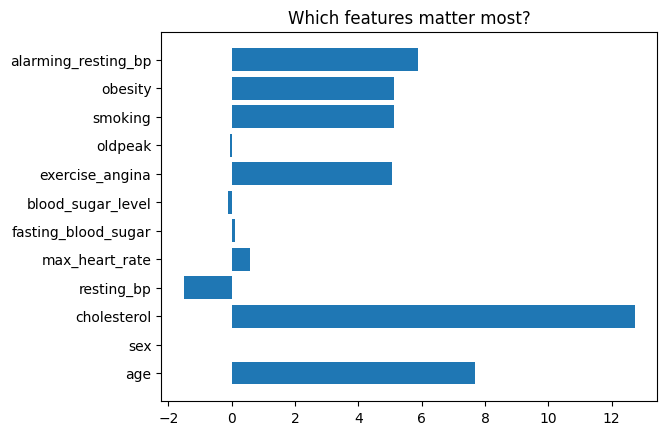

In [ ]:
import matplotlib.pyplot as plt


importance = model.coef_[0]
feature_names = x_train.columns


plt.barh(feature_names, importance)
plt.title("Which features matter most?")
plt.show()